In [1]:
import numpy as np
import pandas as pd
import time
from scipy.ndimage.interpolation import rotate

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

import seaborn as sns
%matplotlib inline

import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
transform = transforms.Compose([transforms.ToTensor(), \
                                transforms.Normalize((0, 0, 0), (1, 1, 1))])

trainset = datasets.MNIST(root='data/', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='data/', train=False, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle=False)
X_test, y_test = iter(testloader).next()
X_test = X_test.numpy()
X1 = np.array([rotate(X_test[9978].squeeze(), i, reshape=False) for i in range(60, 120, 5)])
X1 = X1.reshape(X1.shape[0], 1, X1.shape[1], X1.shape[2])

In [3]:
def caloutdim(hin, kernel_size, stride=1, padding=0, dilation=1):
    return int(np.floor((hin+2*padding-dilation*(kernel_size-1)-1)/stride+1))

d = [28]
d.append(caloutdim(d[-1], 5, padding=2))
d.append(caloutdim(d[-1], 2, 2))
d.append(caloutdim(d[-1], 5, padding=2))
d.append(caloutdim(d[-1], 2, 2))
d

[28, 28, 14, 14, 7]

In [4]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x

class LeNet(nn.Module):
    def __init__(self, droprate=0.5):
        super(LeNet, self).__init__()
        self.model = nn.Sequential()
        self.model.add_module('conv1', nn.Conv2d(1, 20, kernel_size=5, padding=2))
        self.model.add_module('dropout1', nn.Dropout2d(p=droprate))
        self.model.add_module('maxpool1', nn.MaxPool2d(2, stride=2))
        self.model.add_module('conv2', nn.Conv2d(20, 50, kernel_size=5, padding=2))
        self.model.add_module('dropout2', nn.Dropout2d(p=droprate))
        self.model.add_module('maxpool2', nn.MaxPool2d(2, stride=2))
        self.model.add_module('flatten', Flatten())
        self.model.add_module('dense3', nn.Linear(50*7*7, 500))
        self.model.add_module('relu3', nn.ReLU())
        self.model.add_module('dropout3', nn.Dropout(p=droprate))
        self.model.add_module('final', nn.Linear(500, 10))
        
    def forward(self, x):
        return self.model(x)
    
class LeNetClassifier:
    def __init__(self, droprate=0.5, batch_size=64, max_epoch=300, lr=0.01):
        self.batch_size = batch_size
        self.max_epoch = max_epoch
        self.lr = lr
        self.model = LeNet(droprate)
        self.model.cuda()
        self.criterion = nn.CrossEntropyLoss().cuda()
        self.optimizer = optim.SGD(self.model.parameters(), lr=lr)
        self.loss_ = []
        
    def fit(self, trainset, verbose=True):
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=self.batch_size, shuffle=True)
        print(self.model)
        for epoch in range(self.max_epoch):
            running_loss = 0
            for i, data in enumerate(trainloader, 0):
                inputs, labels = data
                inputs, labels = Variable(inputs).cuda(), Variable(labels).cuda()
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.data[0]
            self.loss_.append(running_loss / len(trainloader))
            if verbose and ((epoch+1) % (self.max_epoch//10) == 0 or epoch == 0):
                print('Epoch {} loss: {}'.format(epoch+1, self.loss_[-1]))
        return self
    
def predict_class(model, X):
    model = model.eval()
    outputs = model(Variable(X.cuda()))
    _, pred = torch.max(outputs.data, 1)
    model = model.train()
    return pred.cpu().numpy()

def score(model, X, y):
    return np.mean(predict_class(model, X) == y)

def predict(model, X, T=1000):
    standard_pred = predict_class(model, X)
    y1 = []
    y2 = []
    for _ in range(T):
        _y1 = model(Variable(X.cuda())).cpu()
        _y2 = F.softmax(_y1, dim=1)
        y1.append(_y1.data.numpy())
        y2.append(_y2.data.numpy())
    return standard_pred, np.array(y1), np.array(y2)

In [5]:
%%time

lenet1 = LeNetClassifier().fit(trainset)

LeNet(
  (model): Sequential(
    (conv1): Conv2d (1, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (dropout1): Dropout2d(p=0.5)
    (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (conv2): Conv2d (20, 50, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (dropout2): Dropout2d(p=0.5)
    (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (flatten): Flatten(
    )
    (dense3): Linear(in_features=2450, out_features=500)
    (relu3): ReLU()
    (dropout3): Dropout(p=0.5)
    (final): Linear(in_features=500, out_features=10)
  )
)
Epoch 1 loss: 1.1765512890144707
Epoch 30 loss: 0.062384041379700335
Epoch 60 loss: 0.03598022286190407
Epoch 90 loss: 0.025289509679748814
Epoch 120 loss: 0.018099108675141324
Epoch 150 loss: 0.015613067172356505
Epoch 180 loss: 0.012091124243637138
Epoch 210 loss: 0.010123401999410028
Epoch 240 loss: 0.009247995932886341
Epoch 270 loss: 0.008735214461332191
Epoch 300 loss: 0.00784705897

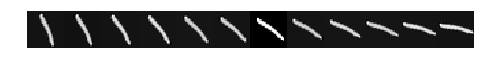

In [6]:
plt.figure(figsize=(8, 1))

gs = gridspec.GridSpec(1, 12)
gs.update(wspace=0, hspace=0)

for i in range(len(X1)):
    plt.subplot(gs[i])
    plt.imshow(X1.squeeze()[i], cmap='gray');
    plt.axis('off');

In [7]:
print('Test score: {}'.format(score(lenet1.model, torch.from_numpy(X_test), y_test)))

Test score: 0.9925


In [8]:
y1_pred, y1_si, y1_so = predict(lenet1.model, torch.from_numpy(X1))
print(y1_pred)

[1 1 1 1 1 2 7 7 7 7 7 7]


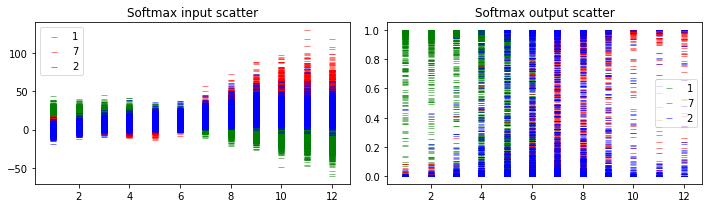

In [11]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.scatter(np.tile(np.arange(1, 13), y1_si.shape[0]), y1_si[:, :, 1].flatten(), \
            color='g', marker='_', linewidth=None, alpha=0.5, label='1');
plt.scatter(np.tile(np.arange(1, 13), y1_si.shape[0]), y1_si[:, :, 7].flatten(), \
            color='r', marker='_', linewidth=None, alpha=0.5, label='7');
plt.scatter(np.tile(np.arange(1, 13), y1_si.shape[0]), y1_si[:, :, 2].flatten(), \
            color='b', marker='_', linewidth=None, alpha=0.5, label='2');
plt.title('Softmax input scatter');
plt.legend(framealpha=0.7);

plt.subplot(1, 2, 2)
plt.scatter(np.tile(np.arange(1, 13), y1_so.shape[0]), y1_so[:, :, 1].flatten(), \
            color='g', marker='_', linewidth=None, alpha=0.5, label='1');
plt.scatter(np.tile(np.arange(1, 13), y1_so.shape[0]), y1_so[:, :, 7].flatten(), \
            color='r', marker='_', linewidth=None, alpha=0.5, label='7');
plt.scatter(np.tile(np.arange(1, 13), y1_so.shape[0]), y1_so[:, :, 2].flatten(), \
            color='b', marker='_', linewidth=None, alpha=0.5, label='2');
plt.title('Softmax output scatter');
plt.legend(framealpha=0.7);

plt.tight_layout();